In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# from huggingface_hub import hf_hub_download
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from segment_anything import build_sam, SamPredictor
from extractor import ViTExtractor
from correspondences import chunk_cosine_sim
import pdb
import warnings
warnings.filterwarnings('ignore')

In [2]:
class VisionModel:
    def __init__(self, device):
        self.device = device
        self.grounding_model = self.load_grounding_model()
        self.sam_model, self.sam_predictor = self.load_sam_model()
        # self.pipe = self.load_diffusion_model()

    def load_grounding_model(self):
        repo_id = "ShilongLiu/GroundingDINO"
        filename = "groundingdino_swinb_cogcoor.pth"
        # ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
        # cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)
        cache_config_file = "./models/grounding_dino_swinb.cfg.py"
        args = SLConfig.fromfile(cache_config_file) 
        model = build_model(args)
        # cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
        cache_file = "./models/groundingdino_swinb_cogcoor.pth"
        checkpoint = torch.load(cache_file, map_location=self.device)
        model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
        model.eval()
        return model

    def load_sam_model(self):
        sam_checkpoint = './models/sam_vit_h_4b8939.pth'
        sam = build_sam(checkpoint=sam_checkpoint)
        sam.to(self.device)
        sam_predictor = SamPredictor(sam)
        return sam, sam_predictor

    def predict_and_visualize_mask(self, image_path, text_prompt):
        from groundingdino.util.inference import load_image, predict, annotate
        image_source, image = load_image(image_path)
        boxes, logits, phrases = predict(
            model=self.grounding_model, 
            image=image, 
            caption=text_prompt, 
            box_threshold=0.3, 
            text_threshold=0.25,
            device=self.device
        )
        annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
        annotated_frame = annotated_frame[..., ::-1]  # BGR to RGB
        masks = vision_model.apply_mask(annotated_frame, boxes)
        annotated_frame_with_mask = vision_model.show_mask(masks[0][0], annotated_frame)

        return annotated_frame_with_mask, masks

    def apply_mask(self, image, boxes):
        self.sam_predictor.set_image(image)
        H, W, _ = image.shape
        boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
        transformed_boxes = self.sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image.shape[:2]).to(self.device)
        masks, _, _ = self.sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
        return masks

    def show_mask(self, mask, image, random_color=True):
        color = np.random.random(3) if random_color else np.array([30/255, 144/255, 255/255])
        color = np.concatenate([color, np.array([0.8])])
        mask = mask.cpu().numpy()
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        annotated_frame_pil = Image.fromarray(image).convert("RGBA")
        mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")
        return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))
    
    def extract_dino_descriptors(self, image_path):
        model_type = 'dino_vits8'
        stride = 4
        layer = 9 
        facet = 'key'
        load_size = 224 

        # extracting descriptors for each image
        self.extractor = ViTExtractor(model_type, stride, device=self.device)
        self.image1_batch, self.image1_pil = self.extractor.preprocess(image_path, load_size)
        # self.image1_batch, self.image1_pil = self.extractor.preprocess(image_path, None)
        descriptors1 = self.extractor.extract_descriptors(self.image1_batch.to(self.device), layer, facet, bin)
        self.num_patches1, load_size1 = self.extractor.num_patches, self.extractor.load_size

        return descriptors1

    def locate_dino_descriptors(self):
        img1_indices_to_show = torch.arange(self.num_patches1[0] * self.num_patches1[1], device=self.device)
        # coordinates in descriptor map's dimensions
        img1_y_to_show = (img1_indices_to_show / self.num_patches1[1]).cpu().numpy()
        img1_x_to_show = (img1_indices_to_show % self.num_patches1[1]).cpu().numpy()

        points1 = []
        for y1, x1 in zip(img1_y_to_show, img1_x_to_show):
            x1_show = (int(x1) - 1) * self.extractor.stride[1] + self.extractor.stride[1] + self.extractor.p // 2
            y1_show = (int(y1) - 1) * self.extractor.stride[0] + self.extractor.stride[0] + self.extractor.p // 2
            points1.append((y1_show, x1_show))

        return points1


    def draw_correspondences(self, points1):
        """
        draw point correspondences on images.
        :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
        :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
        :param image1: a PIL image.
        :param image2: a PIL image.
        :return: two figures of images with marked points.
        """
        num_points = len(points1)
        fig1, ax1 = plt.subplots()
        ax1.axis('off')
        ax1.imshow(self.image1_pil)
        cmap = plt.get_cmap('tab10')
        
        colors = np.array([cmap(x) for x in range(num_points)])
        radius1, radius2 = 1, 0.5
        for point1, color in zip(points1, colors):
            y1, x1 = point1
            circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
            circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
            ax1.add_patch(circ1_1)
            ax1.add_patch(circ1_2)
        return fig1
    
    def interactive_coordinate_recorder(self, image_path, size):
        """
        Display an image and record clicks on the image, storing the pixel coordinates.
        :param image_path: Path to the image file.
        :param size: A tuple indicating the new size (width, height).
        """
        self.coordinates = []  # List to store the coordinates
        self.image_path = image_path
        self.fig, self.ax = plt.subplots()

        # Load and resize the image
        original_image = Image.open(self.image_path)  # Open the image file
        resized_image = original_image.resize(size, resample=Image.NEAREST)  # Resize the image
        self.image = np.array(resized_image)  # Convert the PIL image to a numpy array

        self.ax.imshow(self.image)
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        plt.title('Click on the image to record reference coordinates')
        plt.show()

        return self.coordinates

    def on_click(self, event):
        """
        Event handler for mouse clicks to store coordinates.
        :param event: Mouse click event.
        """
        if event.inaxes is not None:
            x, y = int(event.xdata), int(event.ydata)
            self.coordinates.append((y, x))
            self.ax.plot(x, y, 'ro')  # Mark the clicked points with red circles
            self.fig.canvas.draw()
            print(f"Recorded coordinate: (x={x}, y={y})")


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


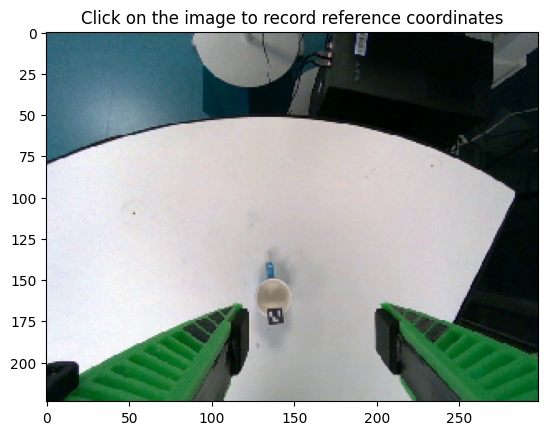

Coordinates recorded: []


Using cache found in /home/krishan/.cache/torch/hub/facebookresearch_dino_main


(298, 224)


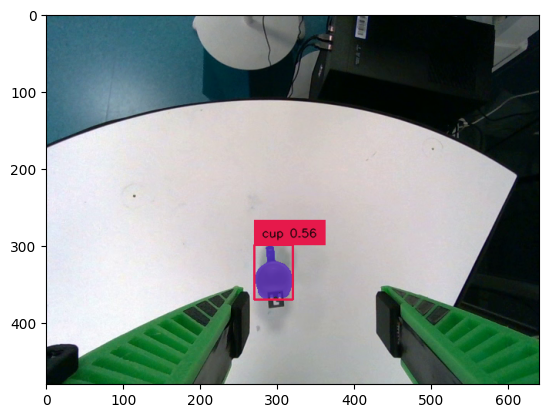

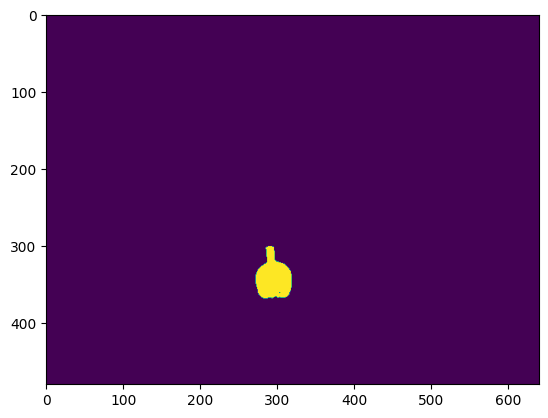

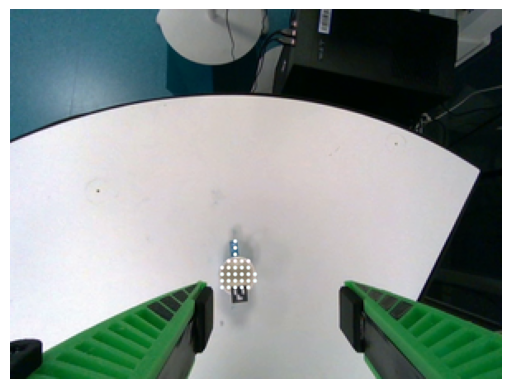

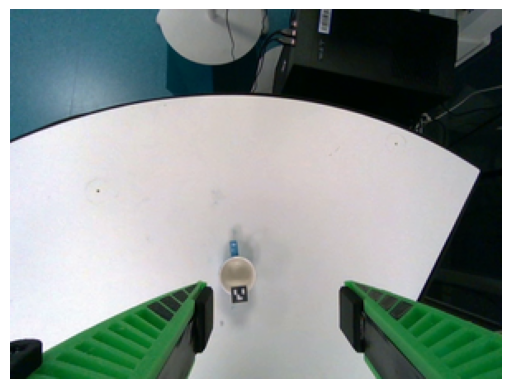

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vision_model = VisionModel(DEVICE)
image_path = './images/cup.png'
text_prompt = "cup"

affordance_centric_coordinates = vision_model.interactive_coordinate_recorder(image_path, (298, 224))
print("Coordinates recorded:", vision_model.coordinates)

annotated_frame, masks = vision_model.predict_and_visualize_mask(image_path, text_prompt)
plt.figure()
plt.imshow(annotated_frame)
plt.figure()
plt.imshow(masks[0][0].cpu().numpy())

extracted_descriptors = vision_model.extract_dino_descriptors(image_path)
descriptor_coordinates = vision_model.locate_dino_descriptors()

binary_mask = masks[0][0].cpu().numpy()
image_size = vision_model.image1_pil.size
print(image_size)
binary_mask = np.array(Image.fromarray(binary_mask).resize(image_size, resample=Image.NEAREST))

# Extract list of coordinates from the mask where the mask is True (or 1)
mask_coordinates = np.argwhere(binary_mask == 1)

# Convert mask_coordinates to a set for faster lookup
mask_coordinate_set = set(map(tuple, mask_coordinates))

# Find all descriptors that are in the mask
object_descriptor_coordinates = [descriptor for descriptor in descriptor_coordinates if tuple(descriptor) in mask_coordinate_set]

# Find the descriptors that are closest to each of the affordance-centric coordinates

closest_descriptor_coordinates = []
for affordance_centric_coordinate in affordance_centric_coordinates:
    closest_descriptor = min(object_descriptor_coordinates, key=lambda descriptor: np.linalg.norm(np.array(descriptor) - np.array(affordance_centric_coordinate)))
    closest_descriptor_coordinates.append(closest_descriptor)

vision_model.draw_correspondences(object_descriptor_coordinates)
vision_model.draw_correspondences(closest_descriptor_coordinates)

# find the idx of the closest descriptor in the descriptor_coordinates list
reference_descriptor_indices = [descriptor_coordinates.index(descriptor) for descriptor in closest_descriptor_coordinates]
reference_descriptors = [extracted_descriptors[0][0][idx] for idx in reference_descriptor_indices]